In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import layers, models
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
nltk.download('punkt')
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# kaggle code to import dataset(autogenerated)

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.




CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-fine-food-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F18%2F2157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240618%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240618T013539Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D49fad753ded92df926f5d825a6b099d80e55150d44955ef1ae3deac4f811dff6636f690def15f2f0828753f261f77a678cc99373754ce08650c26e08994602b7ae74b9aeaa2b05990e2c22982ddaa1f2e84b8c1935cd7133a859b14618af4a21d77c79a8c8b2cd567b28a6bbf44a6945d92e07a3f3edfe2eefe70edbbfb36aa07ab2e746eaeeaba9b098f6f085193cec5c252882e537ae2258cdebfe5d46ea40d3a71060c2f4ce34b3ad876ec4fa6b9b8de40165125aba7fe2b17973f3143e1cddf91ae4518859d1a7734c56e706faf494f8ada5fd4e0e6509c412f169e051ff629e505bc12e653c2474992ae019c1dd75dae1c38c8235e6ca5fafef6e79a7a3'
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[==================================================] 253873708 bytes downloaded
Downloaded and uncompressed: amazon-fine-food-reviews
Data source import complete.
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/database.sqlite


# pre processing dataset

In [3]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")


stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Clean the 'Text' column and create a new column 'Text1'
df['Text1'] = df['Text'].astype(str).apply(remove_stopwords)

def word_count(text):
    return len(text.split())

# Apply the word count function to the 'Text' column
df['WordCount'] = df['Text'].apply(word_count)

# Filter the DataFrame to keep rows with fewer than 200 words
filtered_data = df[df['WordCount'] < 200].copy()
n_rows = len(filtered_data)
rows_to_remove = int(np.floor(9.995 * n_rows / 10))

# Randomly select rows to remove
rows_to_drop = np.random.choice(filtered_data.index, size=rows_to_remove, replace=False)
filtered_data=filtered_data.drop(rows_to_drop)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text1,WordCount
1272,1273,B000WNJ73Q,A22A7OEB664QSC,Kathleen Stept,3,3,5,1092787200,"Healthy, non-fattening, just the right size an...",I've been feeding liver biscotti for years. I ...,I've feeding liver biscotti years. looking hea...,84
1489,1490,B000LRFZE8,A3LJVB19A278FR,"Leah Brown ""Leah Bowser""",0,4,1,1344211200,I never got it,I never got the product and complained about t...,never got product complained non receipt. boug...,21
4011,4012,B000UZVPKO,AN1Z63XXBPKQH,K. Whitfield,7,7,4,1258416000,"Healthy, tasty, convenient, and not too expensive",Sardines are a useful item to stock for times ...,Sardines useful item stock times want add bit ...,136
4214,4215,B004391DK0,A39YG1XNTJTD6Q,J. Miller,0,0,3,1316131200,Bisquick,It is good. I prefer the taste of baking mixes...,"good. prefer taste baking mixes scratch, store...",36
7495,7496,B000LQNCRG,AYLKIYA50SXX1,BIG J,1,1,5,1335398400,great product great service,we enljoy having Loumidis greek coffee every d...,enljoy Loumidis greek coffee every day.Iam exp...,37


In [4]:
len(filtered_data)

267

In [5]:
nltk.download('punkt')
def get_first_sentence(text):
    sentences = sent_tokenize(text)
    if sentences:
        return sentences[0]
    return ""

# Apply the function to create a new column with the first sentence
filtered_data['first_sentence'] = filtered_data['Text'].apply(get_first_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# generate sample reviews from gpt-2

In [6]:


# Load the model and tokenizer
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

def generate_text(prompt, max_length=300):
    # Encode the prompt into tokens
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    # Generate text
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)
    # Decode the generated tokens back to text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Example prompt
prompt = "This tastes like it has artificial sweetener in it and doesn't taste very chocolatey. The name brand cocoa Kkups are better, or just dumping a regular cocoa packet in a cup and running the water through into it is better."
generated_text = generate_text(prompt)

print(generated_text)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


This tastes like it has artificial sweetener in it and doesn't taste very chocolatey. The name brand cocoa Kkups are better, or just dumping a regular cocoa packet in a cup and running the water through into it is better.

I've tried a few different brands of KKups, but I've never had any problems with them. I'm not sure if they're the best or the worst, and I don't know if I'd be able to find a good one. But I do know that they are a great way to get a little bit of sweetness out of a chocolate. They are also a very good way for people to add a bit more sweetness to their chocolate, which is a nice touch. If you're looking for a more traditional way of making Kups then I would recommend this one, as it's a lot more refined and has a much more natural taste. It's also very easy to make. You just need to mix it with a spoon and it will be very smooth.


In [7]:
filtered_data['GeneratedText'] =
filtered_data['first_sentence'].progress_apply(lambda x: generate_text(x))

print(filtered_data[['first_sentence', 'GeneratedText']].head())

  0%|          | 0/267 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  1%|          | 2/267 [00:12<27:24,  6.21s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  1%|          | 3/267 [00:17<25:37,  5.82s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  1%|▏         | 4/267 [00:23<25:29,  5.82s/it]The attention mask and the pad token id were not set. As a conseque

                                         first_sentence  \
1272        I've been feeding liver biscotti for years.   
1489  I never got the product and complained about t...   
4011  Sardines are a useful item to stock for times ...   
4214                                        It is good.   
7495  we enljoy having Loumidis greek coffee every d...   

                                          GeneratedText  
1272  I've been feeding liver biscotti for years. I'...  
1489  I never got the product and complained about t...  
4011  Sardines are a useful item to stock for times ...  
4214  It is good. I'm not sure if I'll ever be able ...  
7495  we enljoy having Loumidis greek coffee every d...  


In [66]:
filtered_data.to_csv('final_amazon_reviews_with_gptreviews.csv', index=False)

In [142]:
filtered_data = pd.read_csv('final_amazon_reviews_with_gptreviews_3.csv')

In [143]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text1,WordCount,first_sentence,GeneratedText
0,171,B0064KO0BU,A104Y49ZQ4CYJ2,"H. Adams ""hollya""",0,0,5,1344816000,Worked great!,I purchased as a giveaway for a baby shower wi...,purchased giveaway baby shower Jungle theme! w...,39,I purchased as a giveaway for a baby shower wi...,I purchased as a giveaway for a baby shower wi...
1,888,B000HDMUQ2,AR37BG23UFBF6,"Cheryl Walser ""cello jello""",0,0,5,1242691200,Highly recomended!,Great taste. Great ingredients. Great texture....,Great taste. Great ingredients. Great texture....,55,Great taste.,Great taste. I'm not sure if it's a good thing...
2,1813,B001RVFDOO,A2UY5TRWQ8SLFC,"Candace D. Stokley ""Stokley""",3,3,5,1289865600,Excellent 2 thumbs up !!!!,"Amazing concept... not fried, not even baked.....","Amazing concept... fried, even baked... Popped...",59,"Amazing concept... not fried, not even baked.....","Amazing concept... not fried, not even baked....."
3,2718,B003NDA970,A14YTWHIFDQQL1,Barry L. Thompson,2,2,5,1300320000,POPCORN DON'T GET ANY BETTER THAN THIS,OVER THE YEARS I HAVE BOUGHT A LOT OF POPCORN ...,YEARS BOUGHT LOT POPCORN POPPING FOUND SMALL B...,95,OVER THE YEARS I HAVE BOUGHT A LOT OF POPCORN ...,OVER THE YEARS I HAVE BOUGHT A LOT OF POPCORN ...
4,3068,B000FDKQCO,A1ZW8ORSPZL3K5,vic33,2,2,5,1278979200,Hodgson mill brownie mix,"Good, but I add a cup of whole wheat flour and...","Good, add cup whole wheat flour tsp. baking po...",48,"Good, but I add a cup of whole wheat flour and...","Good, but I add a cup of whole wheat flour and..."


# SVM

## Build model and Train

In [68]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_data['Text1'])
# Split data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
# Train one-class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto').fit(X_train)
# Predict anomalies on training data
y_train_pred = ocsvm.predict(X_train)
y_train_pred = [1 if y == 1 else 0 for y in y_train_pred]  # Convert to binary labels
# Predict anomalies on validation data
y_val_pred = ocsvm.predict(X_val)
y_val_pred = [1 if y == 1 else 0 for y in y_val_pred]  # Convert to binary labels
# Report training error
train_accuracy = accuracy_score([1]*len(y_train_pred), y_train_pred)
print(f'Training Accuracy: {train_accuracy:.2f}')
# Report validation error
val_accuracy = accuracy_score([1]*len(y_val_pred), y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')

# Detailed classification report
print("Training Classification Report:")
print(classification_report([1]*len(y_train_pred), y_train_pred))

print("Validation Classification Report:")
print(classification_report([1]*len(y_val_pred), y_val_pred))

Training Accuracy: 0.52
Validation Accuracy: 0.40
Training Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.69       427

    accuracy                           0.52       427
   macro avg       0.50      0.26      0.34       427
weighted avg       1.00      0.52      0.69       427

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.40      0.57       107

    accuracy                           0.40       107
   macro avg       0.50      0.20      0.29       107
weighted avg       1.00      0.40      0.57       107



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

## apply PCA

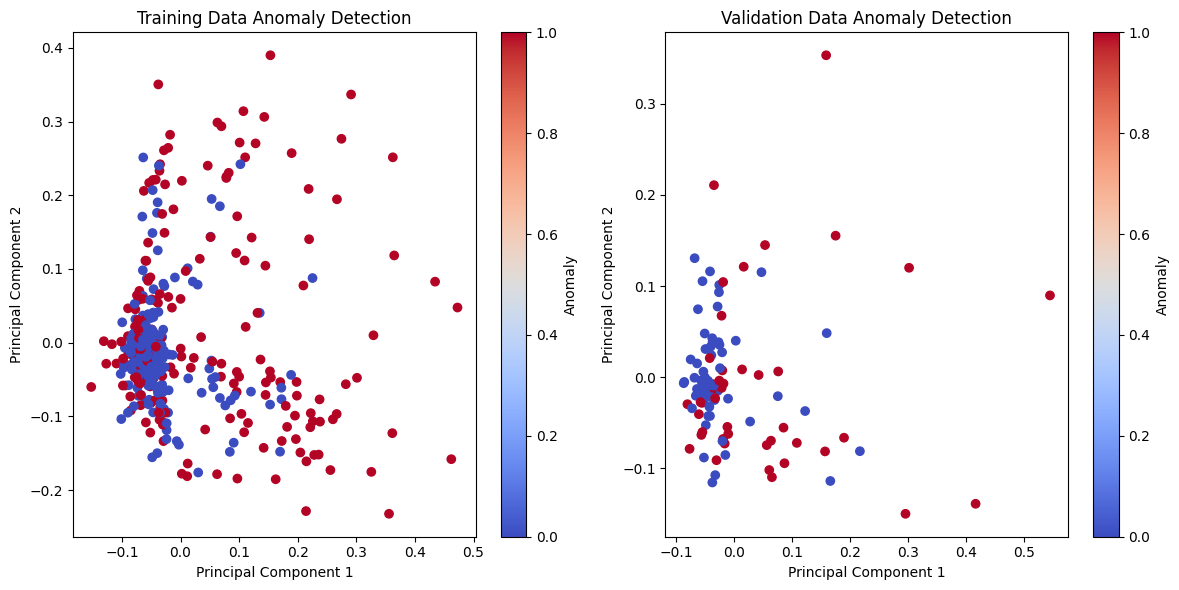

In [69]:
# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.toarray())
X_val_pca = pca.transform(X_val.toarray())

# Scatter plot for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_pred, cmap='coolwarm', marker='o')
plt.title('Training Data Anomaly Detection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Anomaly')

# Scatter plot for validation data
plt.subplot(1, 2, 2)
plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c=y_val_pred, cmap='coolwarm', marker='o')
plt.title('Validation Data Anomaly Detection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Anomaly')

plt.tight_layout()
plt.show()

In [70]:
all_reviews = filtered_data['Text'].tolist() + filtered_data['GeneratedText'].tolist()

In [71]:
all_reviews = pd.DataFrame(all_reviews, columns=['Text1'])
all_reviews.head()

,Text1
0,I purchased as a giveaway for a baby shower wi...
1,Great taste. Great ingredients. Great texture....
2,"Amazing concept... not fried, not even baked....."
3,OVER THE YEARS I HAVE BOUGHT A LOT OF POPCORN ...
4,"Good, but I add a cup of whole wheat flour and..."


In [72]:
vectorizer_generated = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)
X_all = vectorizer_generated.fit_transform(filtered_data['GeneratedText'])
X_all.shape

(534, 4240)

In [73]:
# Predict anomalies on gpt2 generated data
y_all_pred = ocsvm.predict(X_all)
y_all_pred_label = [1 if y == 1 else 0 for y in y_all_pred]  # Convert to binary labels
x_generated =np.ones(len(y_all_pred))

In [83]:
print("------------SVM--------------------------------------")
print("no of non anomalies:",y_all_pred_label.count(1),"total instances:",X_all.shape[0])

------------SVM--------------------------------------
no of non anomalies: 441 total instances: 534


In [84]:

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(x_generated, y_all_pred_label)

In [85]:
conf_matrix

array([[  0,   0],
       [ 93, 441]])

## no of anomalies % in svm
 93/534 =17.4 %

In [86]:

anomalous_reviews_df = pd.DataFrame({'anomalous_reviews': [review for review, label in zip(filtered_data['GeneratedText'], y_all_pred_label) if label == 0]})
non_anom_reviews_df = pd.DataFrame({'non_anom_reviews': [review for review, label in zip(filtered_data['GeneratedText'], y_all_pred_label) if label == 1]})

In [136]:
anomalous_reviews_df.to_csv('anomalous_reviews_df.csv')

In [87]:
anomalous_reviews = anomalous_reviews_df['anomalous_reviews'].tolist()
vectorizer_anomalous = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)
X_anomalous = vectorizer_anomalous.fit_transform(anomalous_reviews)

# Perform PCA
pca = PCA(n_components=2)
X_anomalous_pca = pca.fit_transform(X_anomalous.toarray())

# Get the top 100 words contributing to the principal components
top_n = 100
components = pca.components_
feature_names = vectorizer_anomalous.get_feature_names_out()

# Get the top words for each principal component
top_words_pc1 = [feature_names[i] for i in components[0].argsort()[-top_n:]]
top_words_pc2 = [feature_names[i] for i in components[1].argsort()[-top_n:]]

# Combine and remove duplicates
top_words = list(set(top_words_pc1 + top_words_pc2))

# Print the top words
print(f"Top {top_n} words contributing to the principal components:")
print(top_words[:top_n])

Top 100 words contributing to the principal components:
['vet', 'our', 'beet', 'shower', 'fat', 'chili', 'slimy', 'it', '30', 'll', 'us', 'family', 'expected', 'work', 'are', 'say', 'cousins', 'hands', 'not', 'care', 'alternative', 'home', 'hi', 'person', 'children', 'we', 'think', 'grateful', 'blend', 'stinky', 'getting', 'have', 'well', 'dogs', 'her', 'help', 'cookies', 'guy', 'for', 'goal', 'be', 'pet', 'years', 'he', 'know', 'lucky', 'read', 'awesome', 'here', 'business', 'expect', 'coffee', 'multiple', 'working', 'all', 'customer', 'try', 'four', 'cat', 'going', 'him', 'toys', 'forward', 'been', 'rescued', 'make', 'absolutely', 'book', 'away', 'own', 'ads', 'hospital', 'members', 'to', 'go', 'there', 'had', 're', 'table', 'so', 'if', 'happy', 'figure', 'what', 'bring', 'treats', 'chew', 've', 'large', 'losing', 'man', 'affordable', 'just', 'concerned', 'deal', 'next', 'anything', 'again', 'purchasing', 'house']


## SVM robust training

In [90]:
dfgloveT=pd.read_csv('final_glove_text.csv')
dfgloveT.head()

,0
0,I purchased as giveaway for baby shower with J...
1,Great Great Great Absolutely They are little s...
2,Amazing not not even Popped like is another pr...
3,OVER THE YEARS I HAVE BOUGHT A LOT OF POPCORN ...
4,but I add cup whole wheat flour baking powder ...


In [91]:
midpoint = len(dfgloveT) // 2

# Slice the first half of the generated_text column
first_half_generated_text = dfgloveT['0'].iloc[:midpoint]

# Concatenate the first half of generated_text and the entire text column vertically
new_data = pd.concat([first_half_generated_text, filtered_data['Text']], axis=0).reset_index(drop=True)

# Convert the Series into a DataFrame with one column named 'combined_text'
new_data = new_data.to_frame(name='combined_text')

In [92]:
vectorizer2 = TfidfVectorizer()
X_gen = vectorizer2.fit_transform(new_data['combined_text'])

In [97]:
X_gen.shape

(801, 4271)

In [93]:
X_train_r, X_val_r = train_test_split(X_gen, test_size=0.8, random_state=42)

# Train one-class SVM
ocsvmr = OneClassSVM(kernel='rbf', gamma='auto').fit(X_train_r)

# Predict anomalies on training data
y_train_predr = ocsvmr.predict(X_train_r)
y_train_predr = [1 if y == 1 else 0 for y in y_train_predr]  # Convert to binary labels

# Predict anomalies on validation data
y_val_predr = ocsvmr.predict(X_val_r)
y_val_predr = [1 if y == 1 else 0 for y in y_val_predr]  # Convert to binary labels

# Report training error
train_accuracyr = accuracy_score([1]*len(y_train_predr), y_train_predr)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Report validation error
val_accuracyr = accuracy_score([1]*len(y_val_predr), y_val_predr)
print(f'Validation Accuracy: {val_accuracy:.2f}')

# Detailed classification report
print("Training Classification Report:")
print(classification_report([1]*len(y_train_predr), y_train_predr))

print("Validation Classification Report:")
print(classification_report([1]*len(y_val_predr), y_val_predr))

Training Accuracy: 0.52
Validation Accuracy: 0.40
Training Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.49      0.66       160

    accuracy                           0.49       160
   macro avg       0.50      0.24      0.33       160
weighted avg       1.00      0.49      0.66       160

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.34      0.51       641

    accuracy                           0.34       641
   macro avg       0.50      0.17      0.26       641
weighted avg       1.00      0.34      0.51       641



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [95]:
vectorizer_generated2 = TfidfVectorizer(vocabulary=vectorizer2.vocabulary_)
test_generated_text = filtered_data['GeneratedText']
X_all2 = vectorizer_generated2.fit_transform(test_generated_text)
X_all2.shape

(534, 4271)

In [99]:

y_all_pred2 = ocsvmr.predict(X_all2)
y_all_pred_label2 = [1 if y == 1 else 0 for y in y_all_pred2]  # Convert to binary labels
print("no of anomalies:",X_all2.shape[0] - y_all_pred_label2.count(1),"no of instances:",X_all2.shape[0])
x_generated1 =np.ones(len(y_all_pred2))

no of anomalies: 104 no of instances: 534


In [103]:
conf_matrix2 = confusion_matrix(x_generated1, y_all_pred_label2)
print(conf_matrix2)

[[  0   0]
 [104 430]]


### SVM robust training result
  
accuracy didnot change much .
accuracy =19.4%. this can be attributed to the fact that vocab of the robust traning had more words.



# MPNET

## Build model and generate embeddings

In [144]:


# Load MPNet model and tokenizer
tokenizer_mpnet = AutoTokenizer.from_pretrained('microsoft/mpnet-base')
model_mpnet = AutoModel.from_pretrained('microsoft/mpnet-base')

def encode_texts(texts, batch_size=32):
    encoded_outputs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        encoded_inputs = tokenizer_mpnet(batch_texts, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model_mpnet(**encoded_inputs)
        encoded_outputs.append(outputs.last_hidden_state.mean(dim=1).numpy())
    return np.concatenate(encoded_outputs, axis=0)

# Encode the cleaned texts
encoded_texts = encode_texts(filtered_data['Text'].tolist())

# Standardize the encoded texts
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_texts)
n_components= min(50, scaled_data.shape[0], scaled_data.shape[1])
# Reduce dimensionality
pca = PCA(n_components=min(50, scaled_data.shape[0], scaled_data.shape[1]))
reduced_data = pca.fit_transform(scaled_data)
train_data, val_data = train_test_split(reduced_data, test_size=0.2, random_state=42)
# Build the autoencoder
input_dim = reduced_data.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(train_data, train_data, epochs=10, batch_size=32, shuffle=True, validation_data=(val_data, val_data))




Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 17/17 [09:03<00:00, 31.97s/it]


Epoch 1/10
14/14 [==============================] - 1s 17ms/step - loss: 12.3141 - val_loss: 11.6064
Epoch 2/10
14/14 [==============================] - 0s 5ms/step - loss: 12.2177 - val_loss: 11.5324
Epoch 3/10
14/14 [==============================] - 0s 4ms/step - loss: 12.1303 - val_loss: 11.4615
Epoch 4/10
14/14 [==============================] - 0s 5ms/step - loss: 12.0410 - val_loss: 11.3912
Epoch 5/10
14/14 [==============================] - 0s 5ms/step - loss: 11.9499 - val_loss: 11.3226
Epoch 6/10
14/14 [==============================] - 0s 6ms/step - loss: 11.8639 - val_loss: 11.2566
Epoch 7/10
14/14 [==============================] - 0s 6ms/step - loss: 11.7864 - val_loss: 11.2007
Epoch 8/10
14/14 [==============================] - 0s 7ms/step - loss: 11.7202 - val_loss: 11.1491
Epoch 9/10
14/14 [==============================] - 0s 6ms/step - loss: 11.6653 - val_loss: 11.1064
Epoch 10/10
14/14 [==============================] - 0s 6ms/step - loss: 11.6191 - val_loss: 11.070

In [145]:
# Print the training loss
print("Training Loss per Epoch:")
for epoch, loss in enumerate(history.history['loss']):
    print(f"Epoch {epoch + 1}: Loss = {loss}")

# Save the model
autoencoder.save('mpnet_autoencoder1.h5')

Training Loss per Epoch:
Epoch 1: Loss = 12.314107894897461
Epoch 2: Loss = 12.217726707458496
Epoch 3: Loss = 12.130318641662598
Epoch 4: Loss = 12.041013717651367
Epoch 5: Loss = 11.949926376342773
Epoch 6: Loss = 11.863897323608398
Epoch 7: Loss = 11.786419868469238
Epoch 8: Loss = 11.720232963562012
Epoch 9: Loss = 11.665299415588379
Epoch 10: Loss = 11.619070053100586


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [146]:
import pickle
with open('filename.pickle', 'wb') as handle:
    pickle.dump(ocsvm, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Detect Anomalies

In [147]:
def detect_anomalies(data, threshold=.5):
    reconstructions = autoencoder.predict(data)
    mse = np.mean(np.square(reconstructions - data), axis=1)
    mean_mse = np.mean(mse)
    std_mse = np.std(mse)
    anomaly_threshold = mean_mse + threshold * std_mse
    anomalies = mse > anomaly_threshold
    return anomalies, mse

In [148]:

# Detect anomalies in the generated texts
generated_anomalies, generated_mse = detect_anomalies(reduced_data)
filtered_data['Anomaly'] = generated_anomalies
filtered_data['ReconstructionError'] = generated_mse

# Save the final DataFrame to a CSV file
filtered_data.to_csv('final_amazon_reviews_with_anomalies.csv', index=False)

print("Processing completed. Results saved to 'final_amazon_reviews_with_anomalies.csv'.")


17/17 [==============================] - 0s 2ms/step
Processing completed. Results saved to 'final_amazon_reviews_with_anomalies.csv'.


### Plots to visualize anomalies

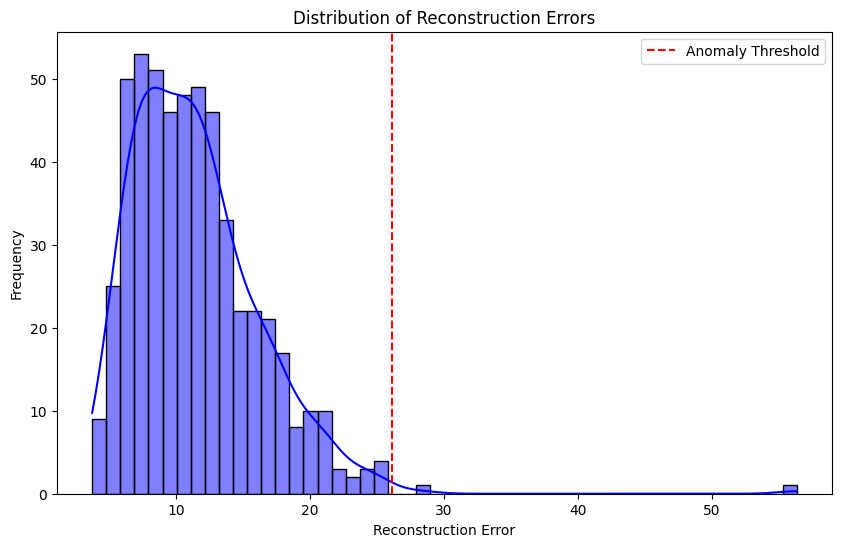

In [109]:
# Visualize the anomaly detection results
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['ReconstructionError'], bins=50, kde=True, color='blue')
plt.axvline(x=filtered_data['ReconstructionError'].mean() + 3 * filtered_data['ReconstructionError'].std(), color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


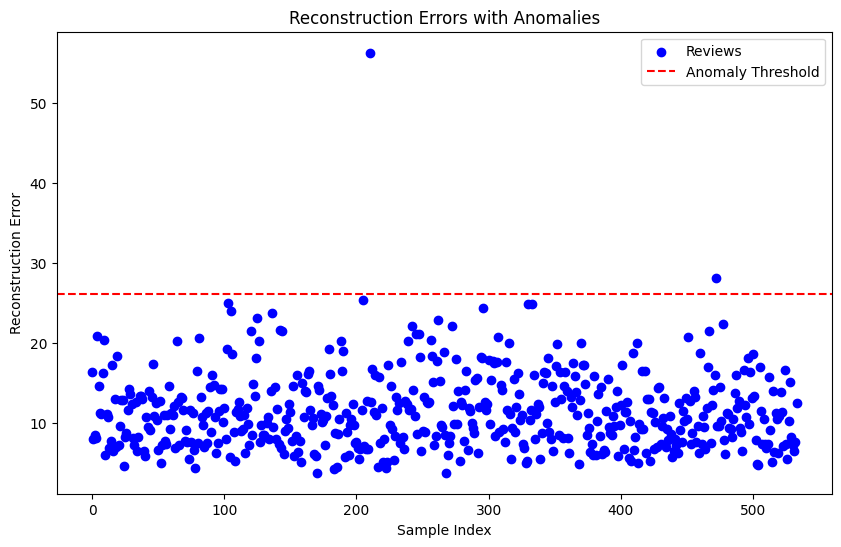

In [110]:
# Scatter plot to visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(range(len(filtered_data)), filtered_data['ReconstructionError'], color='blue', label='Reviews')
plt.axhline(y=filtered_data['ReconstructionError'].mean() + 3 * filtered_data['ReconstructionError'].std(), color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Errors with Anomalies')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

## Test/predict anomalies on GPT2 generated test reviews data

In [149]:
encoded_gen_texts = encode_texts(filtered_data['GeneratedText'].tolist())

# Standardize the encoded texts
scalerg = StandardScaler()
scaled_datag = scalerg.fit_transform(encoded_gen_texts)
n_components= min(50, scaled_datag.shape[0], scaled_datag.shape[1])
# Reduce dimensionality
pca = PCA(n_components=min(50, scaled_datag.shape[0], scaled_datag.shape[1]))
reduced_gen_data = pca.fit_transform(scaled_datag)


100%|██████████| 17/17 [12:56<00:00, 45.70s/it]


In [150]:
gen_anomalies, gen_mse = detect_anomalies(reduced_gen_data)
filtered_data['Anomaly_mp'] = gen_anomalies
filtered_data['ReconstructionError_mp'] = gen_mse


# Save the final DataFrame to a CSV file
filtered_data.to_csv('final_amazon_reviews_with_gen_anomls.csv', index=False)

print("Processing completed. Results saved to 'final_amazon_reviews_with_gen_anomls.csv'.")

17/17 [==============================] - 0s 2ms/step
Processing completed. Results saved to 'final_amazon_reviews_with_gen_anomls.csv'.


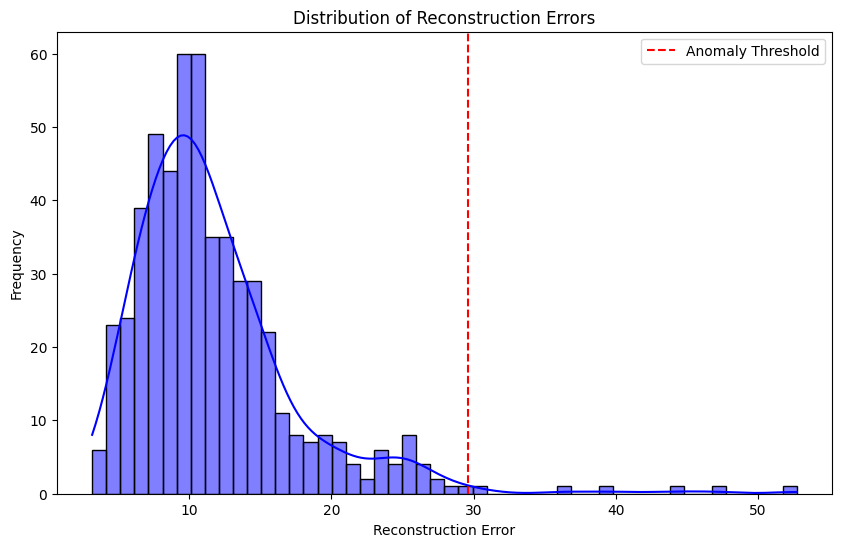

In [118]:
# Visualize the anomaly detection results
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['ReconstructionError_mp'], bins=50, kde=True, color='blue')
plt.axvline(x=filtered_data['ReconstructionError_mp'].mean() + 3 * filtered_data['ReconstructionError_mp'].std(), color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

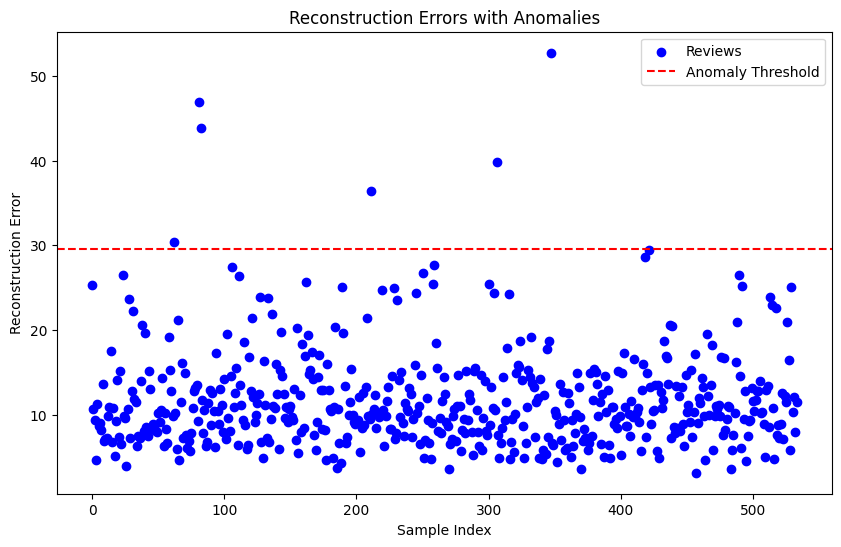

In [119]:
# Scatter plot to visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(range(len(filtered_data)), filtered_data['ReconstructionError_mp'], color='blue', label='Reviews')
plt.axhline(y=filtered_data['ReconstructionError_mp'].mean() + 3 * filtered_data['ReconstructionError_mp'].std(), color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Errors with Anomalies')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

##  no of anomalies in MPnet
   num_anmalies= 56/267 = 21%

In [115]:
num_anomalies = (filtered_data['Anomaly_mp'] == True).sum()
print(num_anomalies,len(filtered_data['GeneratedText']))

109 534


In [116]:
anomalous_reviews_mp = pd.DataFrame({'anomalous_reviews': [review for review, label in zip(filtered_data['GeneratedText'], filtered_data['Anomaly_mp']) if label == True]})
non_anom_reviews_mp = pd.DataFrame({'non_anom_reviews': [review for review, label in zip(filtered_data['GeneratedText'], filtered_data['Anomaly_mp']) if label == False]})

## MP robust training

In [117]:
new_data.head()

,combined_text
0,I purchased as giveaway for baby shower with J...
1,Great Great Great Absolutely They are little s...
2,Amazing not not even Popped like is another pr...
3,OVER THE YEARS I HAVE BOUGHT A LOT OF POPCORN ...
4,but I add cup whole wheat flour baking powder ...


In [120]:
# Encode the cleaned texts
encoded_texts = encode_texts(new_data['combined_text'].tolist())

# Standardize the encoded texts
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_texts)
n_components= min(50, scaled_data.shape[0], scaled_data.shape[1])
# Reduce dimensionality
pca = PCA(n_components=min(50, scaled_data.shape[0], scaled_data.shape[1]))
reduced_data = pca.fit_transform(scaled_data)
train_data, val_data = train_test_split(reduced_data, test_size=0.2, random_state=42)
# Build the autoencoder
input_dim = reduced_data.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(train_data, train_data, epochs=10, batch_size=32, shuffle=True, validation_data=(val_data, val_data))




100%|██████████| 26/26 [10:45<00:00, 24.83s/it]


Epoch 1/10
20/20 [==============================] - 2s 18ms/step - loss: 11.8558 - val_loss: 11.6677
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 11.7053 - val_loss: 11.5375
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 11.5607 - val_loss: 11.4110
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 11.4324 - val_loss: 11.2939
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 11.3252 - val_loss: 11.2110
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 11.2438 - val_loss: 11.1482
Epoch 7/10
20/20 [==============================] - 0s 4ms/step - loss: 11.1798 - val_loss: 11.1019
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 11.1270 - val_loss: 11.0587
Epoch 9/10
20/20 [==============================] - 0s 5ms/step - loss: 11.0820 - val_loss: 11.0233
Epoch 10/10
20/20 [==============================] - 0s 4ms/step - loss: 11.0431 - val_loss: 10.996

In [121]:
# Print the training loss
print("Training Loss per Epoch:")
for epoch, loss in enumerate(history.history['loss']):
    print(f"Epoch {epoch + 1}: Loss = {loss}")

# Save the model
autoencoder.save('mpnet_autoencoder2.h5')

Training Loss per Epoch:
Epoch 1: Loss = 11.85583782196045
Epoch 2: Loss = 11.705347061157227
Epoch 3: Loss = 11.56072998046875
Epoch 4: Loss = 11.432395935058594
Epoch 5: Loss = 11.325220108032227
Epoch 6: Loss = 11.24378776550293
Epoch 7: Loss = 11.179826736450195
Epoch 8: Loss = 11.126986503601074
Epoch 9: Loss = 11.081979751586914
Epoch 10: Loss = 11.043122291564941


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [122]:

# Detect anomalies in the generated texts
generated_anomalies, generated_mse = detect_anomalies(reduced_data)
filtered_dt=pd.DataFrame()

filtered_dt['Anomaly'] = generated_anomalies
filtered_dt['ReconstructionError'] = generated_mse

# Save the final DataFrame to a CSV file
filtered_dt.to_csv('final_amazon_reviews_with_anomalies.csv', index=False)

print("Processing completed. Results saved to 'final_amazon_reviews_with_anomalies.csv'.")


26/26 [==============================] - 0s 1ms/step
Processing completed. Results saved to 'final_amazon_reviews_with_anomalies.csv'.


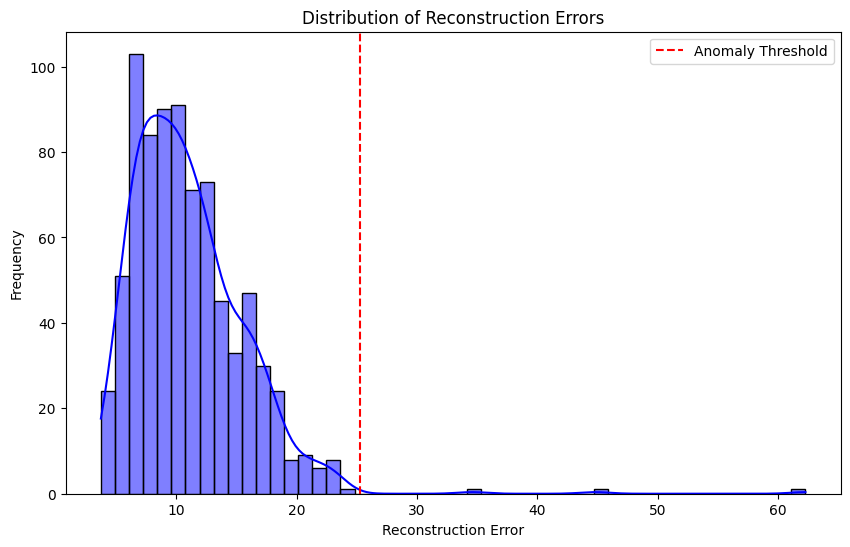

In [123]:
# Visualize the anomaly detection results
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(filtered_dt['ReconstructionError'], bins=50, kde=True, color='blue')
plt.axvline(x=filtered_dt['ReconstructionError'].mean() + 3 * filtered_dt['ReconstructionError'].std(), color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


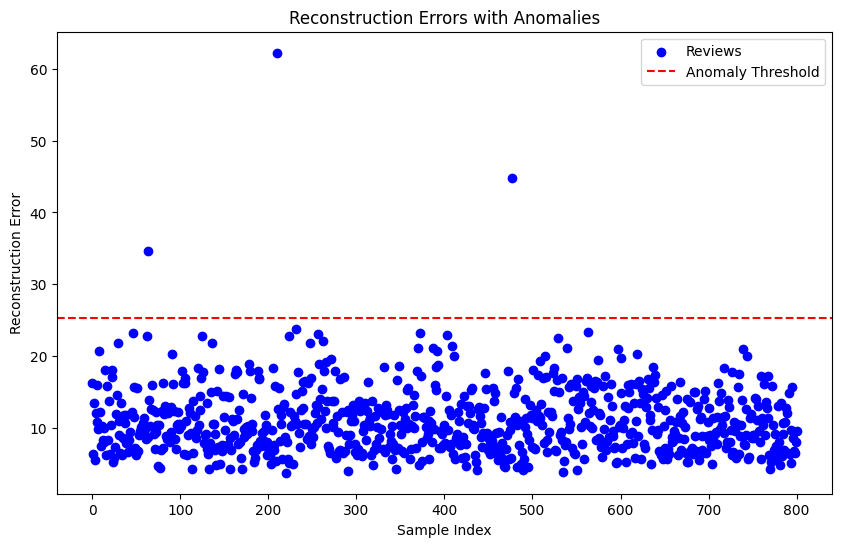

In [124]:
# Scatter plot to visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(range(len(filtered_dt)), filtered_dt['ReconstructionError'], color='blue', label='Reviews')
plt.axhline(y=filtered_dt['ReconstructionError'].mean() + 3 * filtered_dt['ReconstructionError'].std(), color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Errors with Anomalies')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

### apply MPnet to generated reviews test data


In [125]:
encoded_gen_text = encode_texts(list(test_generated_text))

# Standardize the encoded texts
scalerg = StandardScaler()
scaled_datagr = scalerg.fit_transform(encoded_gen_text)
n_components= min(50, scaled_datag.shape[0], scaled_datag.shape[1])
# Reduce dimensionality
pca = PCA(n_components=min(50, scaled_datag.shape[0], scaled_datag.shape[1]))
reduced_gen_datar = pca.fit_transform(scaled_datagr)

100%|██████████| 17/17 [12:24<00:00, 43.77s/it]


In [126]:
gen_anomalies_robust, gen_mse_robust = detect_anomalies(reduced_gen_datar)
tst_dt=pd.DataFrame()
tst_dt['Anomaly_mpr'] = gen_anomalies_robust
tst_dt['ReconstructionError_mpr'] = gen_mse_robust


# Save the final DataFrame to a CSV file
#filtered_data.to_csv('final_amazon_reviews_with_gen_anomls.csv', index=False)

print("Processing completed. Results saved to 'final_amazon_reviews_with_gen_anomls.csv'.")

17/17 [==============================] - 0s 2ms/step
Processing completed. Results saved to 'final_amazon_reviews_with_gen_anomls.csv'.


In [127]:
num_anomalies_robust = (tst_dt['Anomaly_mpr'] == True).sum()
print(num_anomalies_robust,len(tst_dt['Anomaly_mpr']))

110 534


### MP net robust training result
accuracy improved from 20% to 40%

# Try evading

In [151]:
dfglove=pd.read_csv('final_glovex.csv')
dfglove.head()

,0
0,I purchased as giveaway for baby shower with J...
1,Let me keep it short the I'm not going go into...
2,This honestly I'm not sure if I'm going be abl...
3,New product for our We are small family owned ...
4,Good Rated 5 out 5 by Anonymous from Great pro...


# MPnet glove results
out of anomalies detected 2/3 are re-classified as normal.

## Non robust MPnet

In [152]:
encoded_gen_textgl = encode_texts(list(dfglove['0']))

# Standardize the encoded texts
scalergl = StandardScaler()
scaled_datagl = scalerg.fit_transform(encoded_gen_textgl)
n_components= min(50, scaled_datagl.shape[0], scaled_datagl.shape[1])
# Reduce dimensionality
pca = PCA(n_components=min(50, scaled_datagl.shape[0], scaled_datagl.shape[1]))
reduced_gen_datagl = pca.fit_transform(scaled_datagl)

100%|██████████| 4/4 [00:45<00:00, 11.38s/it]


In [153]:
gen_anomalies_robust, gen_mse_robust = detect_anomalies(reduced_gen_datagl)
tst_dtgl=pd.DataFrame()
tst_dtgl['Anomaly_mpr'] = gen_anomalies_robust
tst_dtgl['ReconstructionError_mpr'] = gen_mse_robust

num_anomalies_robust = (tst_dtgl['Anomaly_mpr'] == True).sum()
print(num_anomalies_robust,len(tst_dtgl['Anomaly_mpr']))

4/4 [==============================] - 0s 4ms/step
24 109


# SVM glove results

## Non robust svm-model

In [140]:
vectorizer_generated3 = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)
X_all3 = vectorizer_generated3.fit_transform(dfglove['0'])
y_all_pred3 = ocsvm.predict(X_all3)
y_all_pred_label3 = [1 if y == 1 else 0 for y in y_all_pred3]  # Convert to binary labels
print(y_all_pred_label3.count(1),len(y_all_pred3))

55 109


## Robust SVM-model

In [141]:
vectorizer_generated4 = TfidfVectorizer(vocabulary=vectorizer2.vocabulary_)
X_all4 = vectorizer_generated4.fit_transform(dfglove['0'])
y_all_pred4 = ocsvmr.predict(X_all4)
y_all_pred_label4 = [1 if y == 1 else 0 for y in y_all_pred4]  # Convert to binary labels
print(y_all_pred_label4.count(1),len(y_all_pred4))

58 109
